- General framework of forward and backward inference
- - validate that an experiment works 
- - a statistical model works
- Sample size is highly contextual n = 50 vs n = 50 * 12 = 600
- - Shrinking n
- - order constraints
- - divergences
- Regularizing priors are not biased priors
- - 
- Inference under model misspecification
- - A one-component mixture generates data
- - a two-component mixture is fit to the data

# The problem

Every culture develops rules of thumb that are meant to provide practical guidance. The Anglo-American culture has the saying "A bird in the hand is worth two in the bush." A sure thing of medium benefit is better than a risky thing of large benefit. It comes from 1500s England at a time when many people hunt wild birds. Of course, that is isn't always good advice. Sometimes the extra risk really is worth the extra benefits - especially when the size of the benefit is very large. The [original saying](https://archive.org/stream/proverbsofjohnhe00heywrich/proverbsofjohnhe00heywrich_djvu.txt) in old English is: 

>"Better  one  byrde  in  hand  than  ten  in  the  wood." 

Ten! That's a really big benefit, especially compared to two. I don't know about you but I might be willing to give up one bird if there is good chance at 10. It's not clear that idiom provides a terribly precise criteria for making decisions.

Science is a culture like any other and also develops rules of thumbs. Like old english proverbs, they are sometimes helpful and sometimes not. Our thinking about sample size is often shaped by such rules. I remember my own undergraduate methods textbook told me 100 is a good sample size. Some resources will tell you 30 is a good sample size. Neither of these rules are always helpful. They don't tell you when you are allowed to make an exception nor how to proceed when you decide an exception should be made.

If you pick up a paper with a sample of 18 people, what should you do? Throw it out? Trust it? Something in-between? In this lecture, we'll explore how to think about this kind of question. Along the way, we'll learn a technique for informally studying all sorts of methodological questions - we build simulated datasets where we know the right answers. Then we check whether our statistical model can learn the answers we already know. This will turn out to be an extremely powerful strategy for all sorts of problems.

Reload some familiar functions before we get started.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pymc as pm
import arviz as az

def simulate_experiment(rate=0.60,independents_p=0.05,conformist_p=0.5,n=12,precision=100):
    '''
    rate_of_independents - what proportion of the subjects should be 
    independents, the rest are conformists.
    independents_p - the probability of a mistake from an independent
    conformist_p - the probability of a mistake from a conformist
    n - the number of critical trials in the experiment
    precision - the number of simulated people 
    '''

    data = []

    for i in range(precision):
        
        # decide whether they are independent or conformist
        
        if np.random.choice([1,0],p=[rate, 1-rate]) == 1:
            
            # they are an independent
            # then their errors come from a binomial
            # with a very low error rate
            
            errors = stats.binom(p=independents_p,n=n).rvs()
            
        else:
            
            # they are a conformist
            # then their errors come from a binomial
            # with a high error rate

            errors = stats.binom(p=conformist_p,n=n).rvs()
            
        data.append(errors)

    return np.array(data)

def visualize_asch(n,data):
    data = list(data)

    # counting structure

    outcomes = range(n)
    counts = []
        
    for i in outcomes:

        matches = data.count(i)
        counts.append(matches)
        
    # plotting structure

    plt.bar(outcomes,counts)

# What's a good sample size?

Let's start by asking - is 50 peple enough for the Asch experiment? Well, enough for what? This isn't a terribly well-specified question until we get clear on what our goals are. One goal you might have is to learn the true parameters out there in the world. What is the true error rate of conformists? What proportion of Americans have conformist traits and what proportion have independent traits? 

It is a little bit hard to know what the true rates in the real world are. If we already knew that, then we wouldn't need to run the study. However, we can build a small artifical world where we know the right answers to those questions. If we control the error rate of conformists, we can set it to be whatever number we want. We'll build a world where the `mixture rate=0.60,` `independents_p=0.05` and `conformist_p=0.5`. We'll sample 50 people from this world in order to find out whether that is a sufficient sample size.

In [3]:
sim_data = simulate_experiment(rate=0.60,independents_p=0.05,conformist_p=0.5,n=12,precision=50)

If our bayesian model can infer the numbers we progammed in, that suggests we have a good experimental design.

In [4]:
with pm.Model() as model_1:

    # mixture weights

    w = pm.Dirichlet('w',[1,1])

    # mixture components

    p0 = pm.Beta('p0',1,2) # independent component
    p1 = pm.Beta('p1',2,1) # conformist component
    components = [pm.Binomial.dist(n=12,p=p0),pm.Binomial.dist(n=12,p=p1)]

    # likelihood

    y = pm.Mixture('error',w=w,comp_dists=components,observed=sim_data)

    trace_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


I've added reference values that indicate the true parameter values in orange (using `ref_val=[]`). You can see that the peak of the posterior is usually close to the true value. Just checking the plots visually can be a bit misleading. For example `p0`, the true value is 0.05. The mean of the posterior is a bit far away, visually speaking. But, numerically speaking, the mean of the posterior is 0.043, which is quite close.

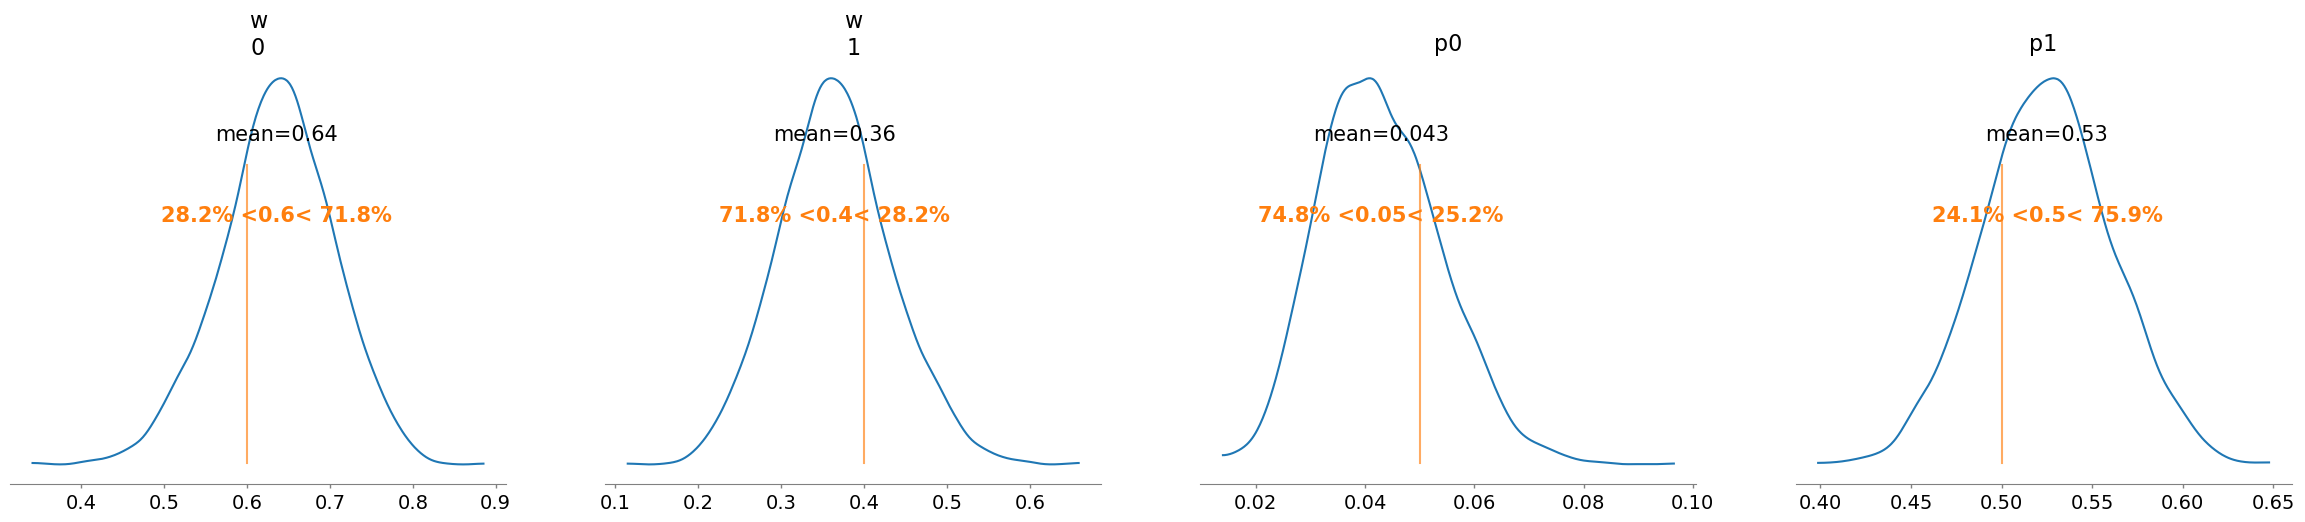

In [10]:
az.plot_posterior(trace_1,ref_val=[0.6,0.4,0.05,0.5],hdi_prob='hide');


How close does it need to be before we say we are good? I don't think there is one right answer to that. Certainly there isn't an algorithmic answer. It requires you to think at the qualitative level - how badly do you need to know the answer? What is at stake in the answer? When testing psychiatric drugs, the stakes can be pretty high. When trying to do "pure" science (research just to understand basic psychological mechanisms), the stakes are less clear but likely fairly low.

We've only studied artifical data. We don't actually know the right answer in the real world. But what we've done is provided some informal evidence that our experiment + our bayesian model are good enough. Now if we apply our Bayesian model to the real data, we should have some confidence our answers are right. Studying simulated world can be very useful for telling us what is a logically valid procedure. It can also tell us what isn't a logically valid procedure too. 

## What's a bad sample size?

Imagine we only have 18 samples. I feel like if I showed you all a paper with only 18 subjects, you would furrow your eyebrows. Is that enough participants?

In [15]:
sim_data = simulate_experiment(rate=0.60,independents_p=0.05,conformist_p=0.5,n=12,precision=18)

In [16]:
with pm.Model() as model_2:

    # mixture weights

    w = pm.Dirichlet('w',[1,1])

    # mixture components

    p0 = pm.Beta('p0',1,2) # independent component
    p1 = pm.Beta('p1',2,1) # conformist component
    components = [pm.Binomial.dist(n=12,p=p0),pm.Binomial.dist(n=12,p=p1)]

    # likelihood

    y = pm.Mixture('error',w=w,comp_dists=components,observed=sim_data)

    trace_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


Well, maybe not. These ranges start to get very wide. The weight parameter now includes anywhere from 0.2 to 0.8. It's mean estimate is off by nearly 10%. Similarly, `p0` is off by about 3%. Maybe these are acceptable ranges. But maybe they aren't 

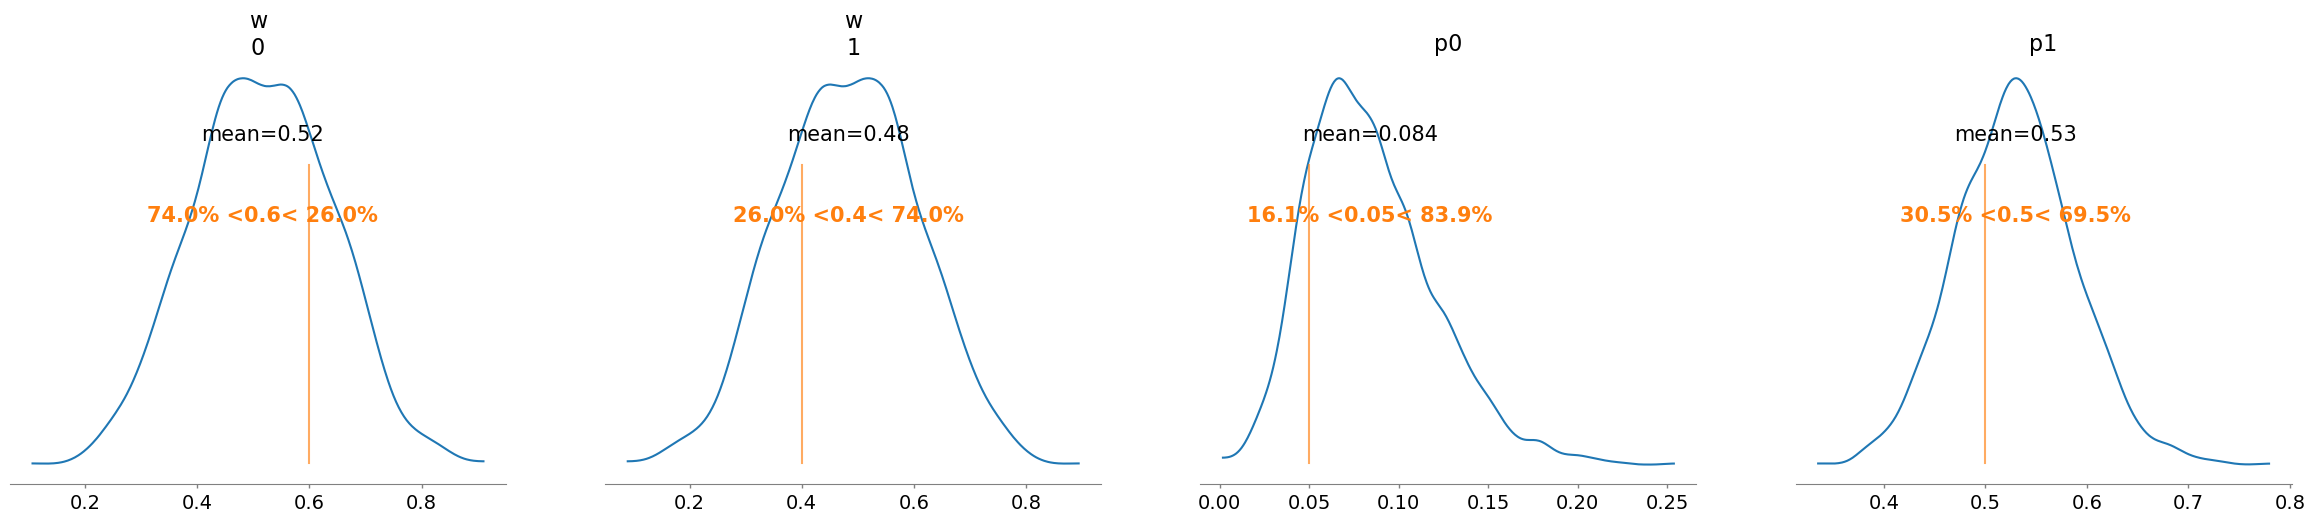

In [20]:
az.plot_posterior(trace_2,ref_val=[0.6,0.4,0.05,0.5],hdi_prob='hide');

One thing to notice, in both this example and the previous one, is that the uncertainty around `w`, the mixture rate, is much wider than the uncertainty around `p`'s, error rates. The mixture rate posterior spans most of the interval between 0 and 1. By contrast, the posteriors for error rates are much tighter. The lesson here is that some parameters are harder to learn than others. In mixture models, there is a natural order on which parameters are easiest to learn. If you don't know what the error rates, it is tough to tell how you should mix them. However, once you lock in on error rates, then it becomes easier to tell what the appropriate mixture is. Uncertainty in some parameters reverberates upward to generate uncertainty in other papers. This phenomena means that what counts as a good sample size can also depend on which parameter you are talking about. If you really care about the mixture rate, it's not clear 50 people is enough.

Let's summarize what we've learned. Asking whether the sample size is big enough isn't actually a very well informed question. It depends on the model you are trying to estimate, what the practical stakes of your problem are and which parameters you care most about. Once you get more clear on your question, however, running simulations can help you plan your experiment. You can figure out, in advance of actually conducting your study, it how many participants would be necessary to satisfy your research goals.

# Thinking forwards and backwards

At this point in the course, you might have started to notice a pattern in how we work through problems. Usually we start with some dataset, think about possible explanations or causes, convert those explanations into simulations, use the simulations to pick out a Bayesian model, define some priors, get estimates and then use those estimates to get predictions. That's a lot of steps and they can start to blur together. It would be helpful if we had some kind of conceptual tool for organizing the process.

One way I like to think about it is that we have two directions of modeling. We can reason from possible underlying causes to what the data should look like. This is what we do when we write a simulation. We'll call this the forward direction and it's usually easier. Then we can reason from data to infer things about the underlying causes look like. We'll call this the backward the direction and it's usually harder. This diagram might be helpful:

![backward_and_forward.png](https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/backward_and_forward.png)

In green, I've highlighted the main components of the forward direction. We might have causal mechanisms combined with some parameter values. Somewhere out there, in the real world, there are really causal mechanisms that have parameters. Together, they generate predictions. In blue, we have the data. That's the only part of the process we ever observe. In orange, I've highlighted the main components of the backward direction. We have the data but we do not know the causal mechanisms or the parameter values that generate them. So we have to make up stories about possible mechanism + what we think about what are plausible parameter values to combine with those mechanisms. At this point we can apply bayes theorem to get a posterior distribution of parameters. Finally, everything loops. Once we have posterior distributions, we can combine those with causal mechanisms to get new predictions. Those posterior distributions can also be reused in future analyses to inform our prior distributions.

The trick we've been exploring in this lecture is that we can test how reliable the loop is if we build synthetic versions of the forward path. If we plug in certain parameters to a causal model, generate artifical data, and then ask a bayesian model to try to learn those parameters, will they return the same numbers we put it. If yes, great. If no, something is wrong. 

# How to tell when you've built the wrong model 

Here's a really weird thing to notice about the scientific method. There aren't any arrows flowing into either causal mechanism nodes. We don't really have an algorithm that tells us what the right models are. Parameter values are nice because, if we pick out the right models and have enough data, eventually we'll learn the right answer. But that whole procedure depends on picking the right models! How do we do that? No amount of bayesian inference is going to tell us what the right models are. Inference about models is always much more qualitative and informal than inference about parameters. Building the right model just requires ingeneity and careful thinking. However, when it comes to identifying a bad model, we do have some tricks to help us.

Last lecture, we notice that visually comparing the model predictions to the data can help - in that case, the data visually appears to have more than two mixture components. So our model is likely bad because it doesn't have enough features. It can also go the other way - our model might have too many features. In that case, the visual checks will look fine. But the MCMC indicate the problem.

To explore this problem, imagine we tried to fit a complex model to a simple data. Unbeknownst to us, our data comes from an ordinary binomial distribution. No mixture.

In [91]:
sim_data = stats.binom(n=12,p=0.15).rvs(50)

But we think there should be a mixture here and happily fix our model.

In [92]:
with pm.Model() as model_misspecification:

    # mixture weights

    w = pm.Dirichlet('w',[1,1])

    # mixture components

    p0 = pm.Beta('p0',1,2) # independent component
    p1 = pm.Beta('p1',2,1) # conformist component
    components = [pm.Binomial.dist(n=12,p=p0),pm.Binomial.dist(n=12,p=p1)]

    # likelihood

    y = pm.Mixture('error',w=w,comp_dists=components,observed=sim_data)

    trace_misspecification = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


We can already see that the Markov Chains are upset. I'll going to ignore that for a minute. Instead, I want to test my model by visually comparing the posterior predictions to the data. 

In [94]:
with model_misspecification:
    predictive_trace = pm.sample_posterior_predictive(trace_misspecification)

Sampling: [error]


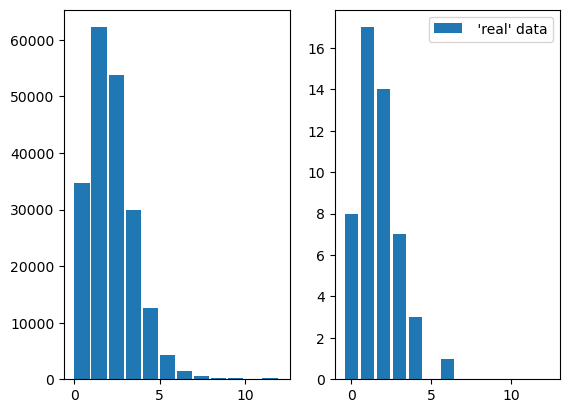

In [102]:
f, ax = plt.subplots(1,2)

# the .flatten() merges all four groups and all 1000 draws into a single long list. 
# So it fits into a histogram much more easily.

predict = predictive_trace.posterior_predictive.error.values.flatten()
ax[0].hist(predict,alpha=1,bins=12,width=0.9,color="tab:blue")

data_sample = list(sim_data)

# counting structure

outcomes = range(13)
counts = []
    
for i in outcomes:

    matches = data_sample.count(i)
    counts.append(matches)
    
# plotting structure

ax[1].bar(outcomes,counts,label=" 'real' data")
plt.legend()

Looks all good to me! Our model clearly captures the structure present in the data. 

How the Markov Chains tell a different story. The mixture compoent is completely diffused across the [0, 1] interval. That's like saying the posterior has no idea where to put the mixture parameter. Meanwhile, a number of our chains for the error rate parameters wander off. They can massively inflated uncertainty for a simple problem.

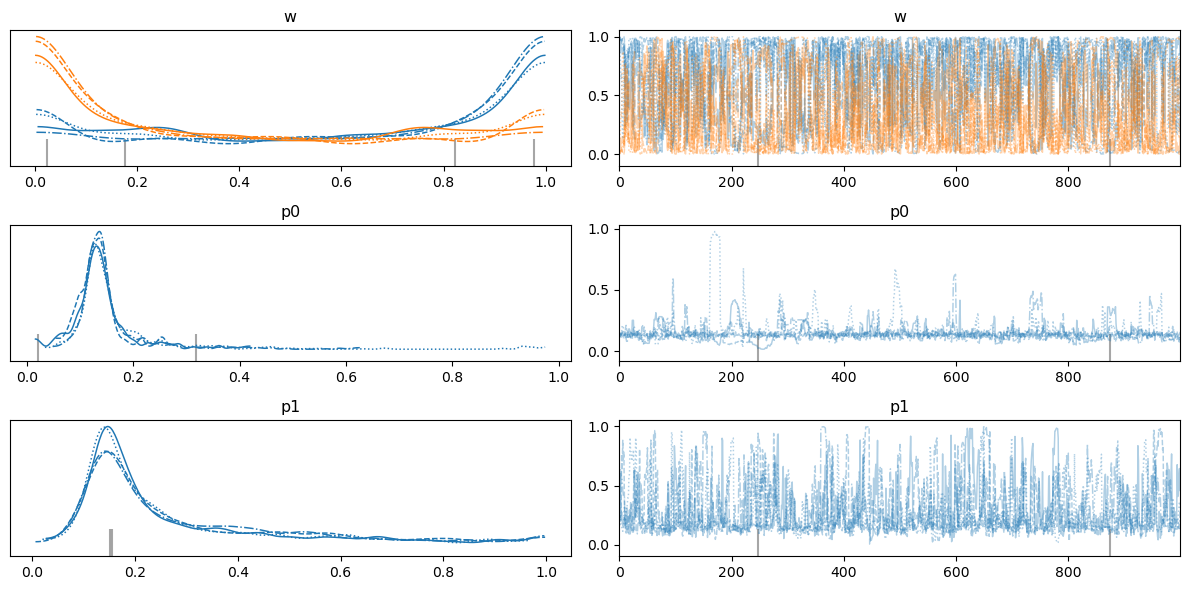

In [93]:
az.plot_trace(trace_misspecification)
plt.tight_layout();

What's happening is that it's trying to push both mixture components into the same location. Either component is sufficient to explain the observed data. So the MCMC just swaps out each component, back and forth. The uncertainty inflates because it has no idea where to put the extra component.

This is a phenomena known as **model misspecification**. It is what happens when we make the wrong assumptions about the causal structure. In this case, we still roughly get the right parameter estimates, `p=0.15`. But we've inflated our uncertainty. If we had just fit a single component simple binomial, it would lock in on the right answer with high precision.

Model misspecification is the single most serious problem in scientific reasoning. When we build the wrong model, it can interfere with everything else. Roughly, we have two different approaches to detect model misspecification.

1. When our model is too simple, that should show up in visual checks against the data. We have a worked example in lecture 13.
2. When our model is too complex, that should show up in bad markov chain behaviour.

This example is cheap because we already know we have the wrong model - we progammed a simple binomial to generate the data. But in more complex problems, it won't be immediately obvious that our model is misspecified.

# More adventures in sample size

So far, we've been talking about the Asch experiment as if the sample size is 50. That makes some sense - there are 50 people. But notice that there are 12 observations per person based on the number of times they conform to the group or not. So maybe we have 12 * 50 observations or a sample size of 600. That number certainly looks more impressive. But which one is the right way to count the sample? Unsurprisingly, I don't think that is a very good question either. It merely points out another ambiguity in what we even mean by "sample size". 

However, I think there is an better question in this neighborhood. Sometimes when people replicate the Asch experiment, that make small adjustments to the experimental setup. Instead of having 12 trials where the group gives the wrong answer, [sometimes](https://psycnet.apa.org/record/1974-08922-001) they have 7. Could this be a big deal? 

Yes, it really could. Let's tweak the parameters of the simulated data a little bit. We'll drop from 12 to 7. Let's also imagine that the new experimental population has slightly different mixture and error rates, maybe arising due to cultural differences.

In [89]:
seed = np.random.seed(13579) 
sim_data = simulate_experiment(rate=0.50,independents_p=0.15,conformist_p=0.4,n=7,precision=50)

In [56]:
# you don't need to know about random seed infrastructure
# I just put this here so that notes remain static and
# the markov chains do the same thing each time.

from numpy.random import RandomState, MT19937, SeedSequence
seed = RandomState(MT19937(SeedSequence(123456789)))

# pymc model

with pm.Model() as model_3:

    # mixture weights

    w = pm.Dirichlet('w',[1,1])

    # mixture components

    p0 = pm.Beta('p0',1,2) # independent component
    p1 = pm.Beta('p1',2,1) # conformist component
    components = [pm.Binomial.dist(n=7,p=p0),pm.Binomial.dist(n=7,p=p1)] 

    # likelihood

    y = pm.Mixture('error',w=w,comp_dists=components,observed=sim_data)

    trace_3 = pm.sample(chains=4,random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The pesky warning about `rhat` is back. We used the gently regularizing priors trick and yet we face the same problem. Visually, our problem looks like this:

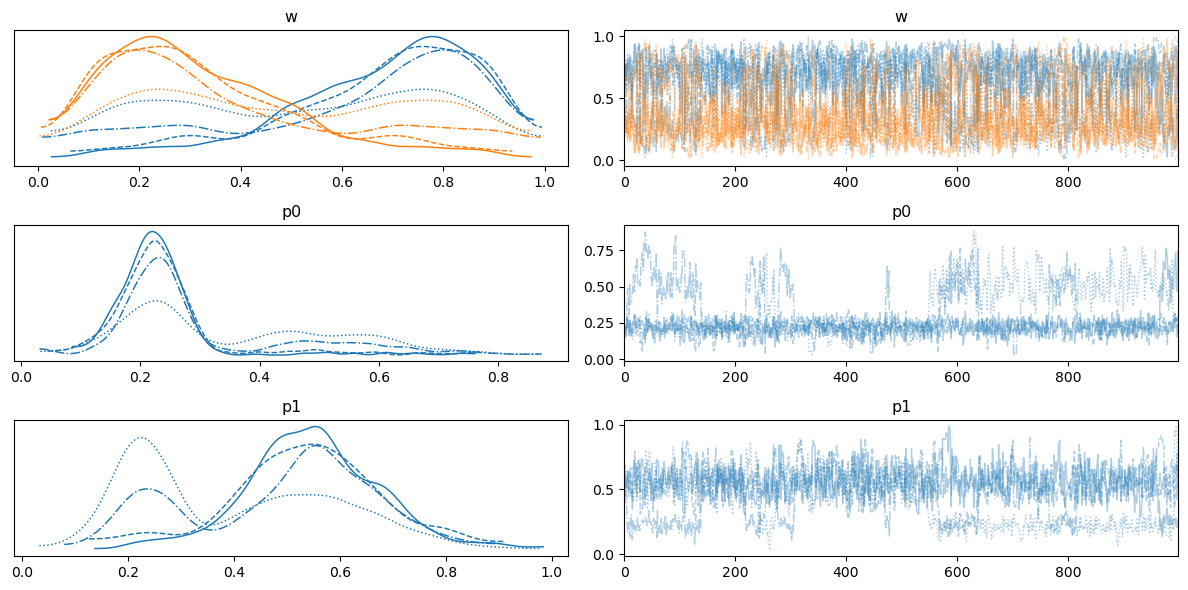

In [57]:
az.plot_trace(trace_3)
plt.tight_layout();

All of these estimates are wrong. The correct `w=0.5`. The correct `p0 = 0.15` and the correct `p1 = 0.4`. We can also see where part of the problem is coming from. For some portion of the sampling, `p1` wandered into `p0`'s space. `p0`, in turn left to take over the rest of the space. In turn, the mixture rates are all off. They think `p0` is the dominant component and can explain nearly all the data. So dropping from 12 to 7 trials per subject isn't a small problem. It blows up our MCMC.

We can get more insight into this problem by inspecting the data visually. It's hard to see where the two components are supposed to go. The visual difficulty is replicated as inferential difficulty. The poor behaviour of our sampler is evidence that this problem is very hard.

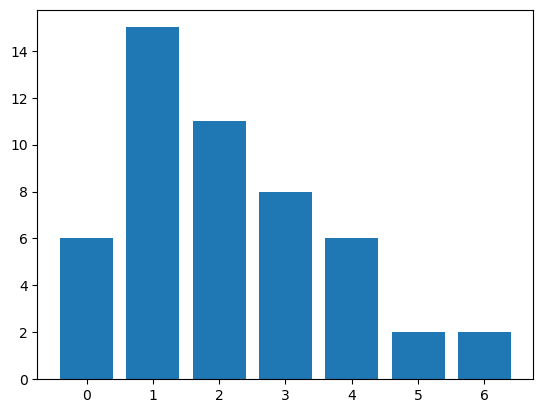

In [90]:
visualize_asch(7,sim_data)

## Order constraints

In [58]:
# pymc model

with pm.Model() as model_4:

    # mixture weights

    w = pm.Dirichlet('w',[1,1])

    # mixture components

    p0 = pm.Beta('p0',1,2) # independent component
    p1 = pm.Beta('p1',2,1) # conformist component
    components = [pm.Binomial.dist(n=7,p=p0),pm.Binomial.dist(n=7,p=p1)]

    # order constraint
    # potentials have a complicated syntax.
    # the steps are, from innermost function to outermost function,
    # - lt = less then
    # - switch = if p0 < p1, return 1 (good). if not, return 0.05 (bad)
    # - log to convert into a scale pymc understands

    pm.Potential('order',pm.math.log(pm.math.switch(pm.math.lt(p0,p1), 1, 0)))

    # likelihood

    y = pm.Mixture('error',w=w,comp_dists=components,observed=sim_data)

    trace_4 = pm.sample(chains=4,random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.


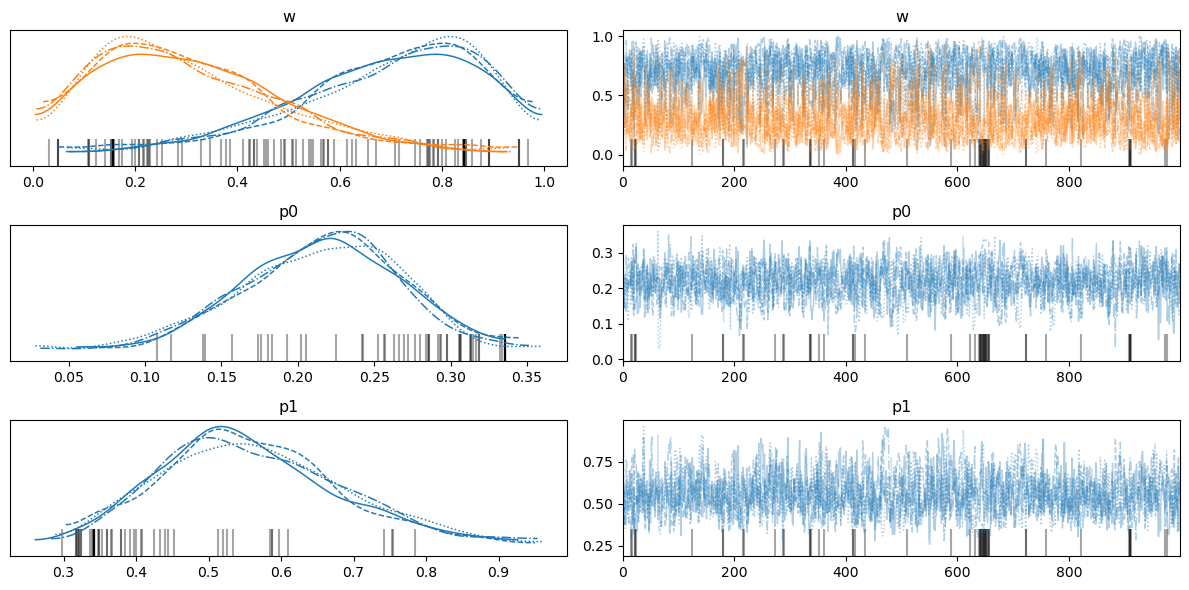

In [59]:
az.plot_trace(trace_4)
plt.tight_layout();

## Divergences

In [28]:
with pm.Model() as divergence_demo_1:
    a = pm.Beta('a',1,1)

    # if a is less than 1, no problem
    # if a is greater than 1, medium sized problem

    pm.Potential('discontinuity',pm.math.log(pm.math.switch(pm.math.lt(a,0.5), 1, 0.1)))

    trace = pm.sample(chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [a]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>]],
      dtype=object)

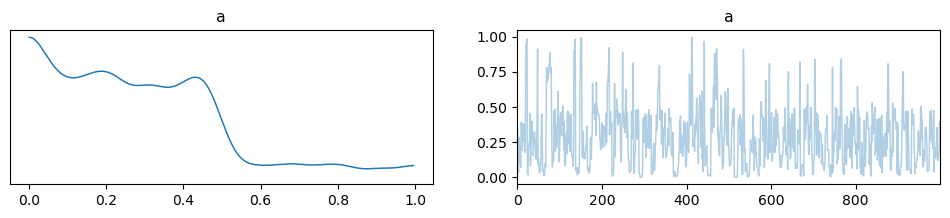

In [29]:
az.plot_trace(trace)

In [22]:
with pm.Model() as divergence_demo_2:
    a = pm.Beta('a',1,1)

    # if a is less than 1, no problem
    # if a is greater than 1, big problem

    pm.Potential('discontinuity',pm.math.log(pm.math.switch(pm.math.lt(a,0.5), 1, 0)))

    trace = pm.sample(chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [a]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>]],
      dtype=object)

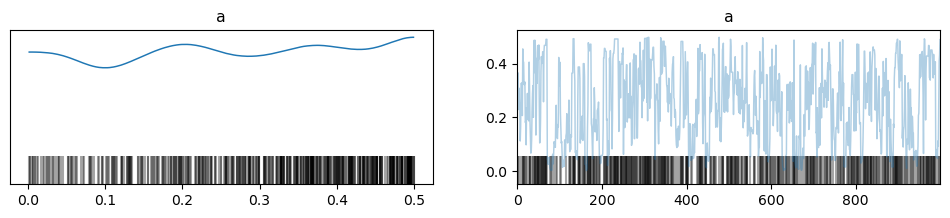

In [23]:
az.plot_trace(trace)

In [62]:
from numpy.random import RandomState, MT19937, SeedSequence
seed = RandomState(MT19937(SeedSequence(123456789)))

# pymc model

with pm.Model() as model_5:

    # mixture weights

    w = pm.Dirichlet('w',[1,1])

    # mixture components

    p0 = pm.Beta('p0',1,2) # independent component
    p1 = pm.Beta('p1',2,1) # conformist component
    components = [pm.Binomial.dist(n=7,p=p0),pm.Binomial.dist(n=7,p=p1)]

    # order constraint
    # potentials have a complicated syntax.
    # the steps are, from innermost function to outermost function,
    # - lt = less then
    # - switch = if p0 < p1, return 1 (good). if not, return 0.05 (bad)
    # - log to convert into a scale pymc understands

    pm.Potential('order',pm.math.log(pm.math.switch(pm.math.lt(p0,p1), 1, 0.05)))

    # likelihood

    y = pm.Mixture('error',w=w,comp_dists=components,observed=sim_data)

    trace_5 = pm.sample(chains=4,random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


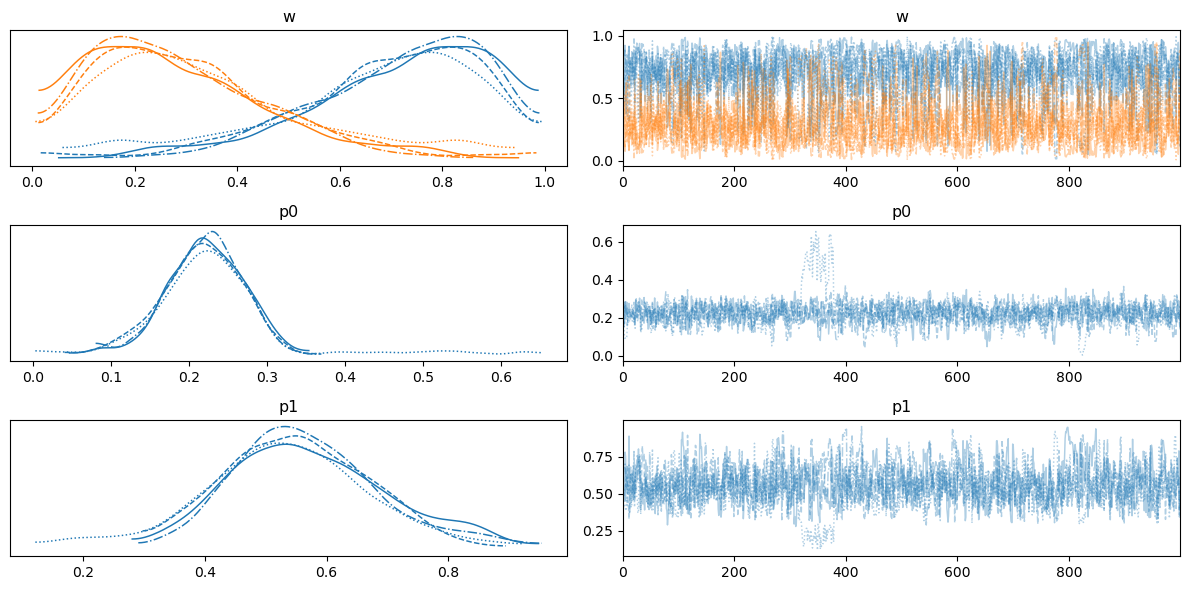

In [63]:
az.plot_trace(trace_5)
plt.tight_layout();

# More regularizing priors

In [69]:
seed = np.random.seed(13579)
sim_data = simulate_experiment(rate=0.50,independents_p=0.15,conformist_p=0.4,n=7,precision=200)

In [74]:
from numpy.random import RandomState, MT19937, SeedSequence
seed = RandomState(MT19937(SeedSequence(123456789)))

# pymc model

with pm.Model() as model_6:

    # mixture weights

    w = pm.Dirichlet('w',[10,10])

    # mixture components

    p0 = pm.Beta('p0',1,2) # independent component
    p1 = pm.Beta('p1',2,1) # conformist component
    components = [pm.Binomial.dist(n=7,p=p0),pm.Binomial.dist(n=7,p=p1)]

    # order constraint
    # potentials have a complicated syntax.
    # the steps are, from innermost function to outermost function,
    # - lt = less then
    # - switch = if p0 < p1, return 1 (good). if not, return 0.05 (bad)
    # - log to convert into a scale pymc understands

    pm.Potential('order',pm.math.log(pm.math.switch(pm.math.lt(p0,p1), 1, 0.05)))

    # likelihood

    y = pm.Mixture('error',w=w,comp_dists=components,observed=sim_data)

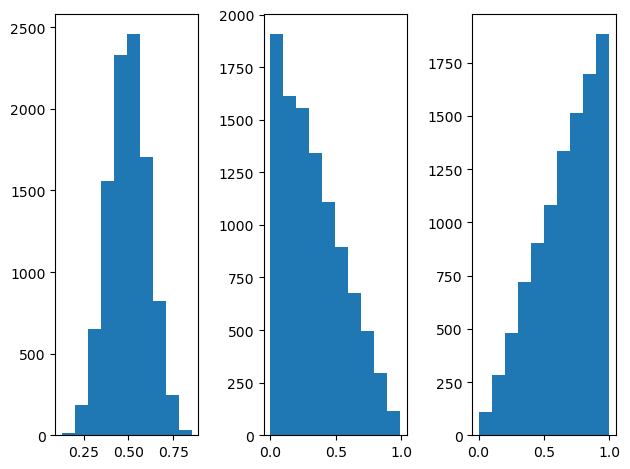

In [75]:
f, ax = plt.subplots(1,3)

w_samples,p0_samples,p1_samples = pm.draw([w,p0,p1],draws=10000)
ax[0].hist(w_samples[:,0])
ax[1].hist(p0_samples)
ax[2].hist(p1_samples)
plt.tight_layout();

In [76]:
with model_6:
    trace_6 = pm.sample(chains=4,random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


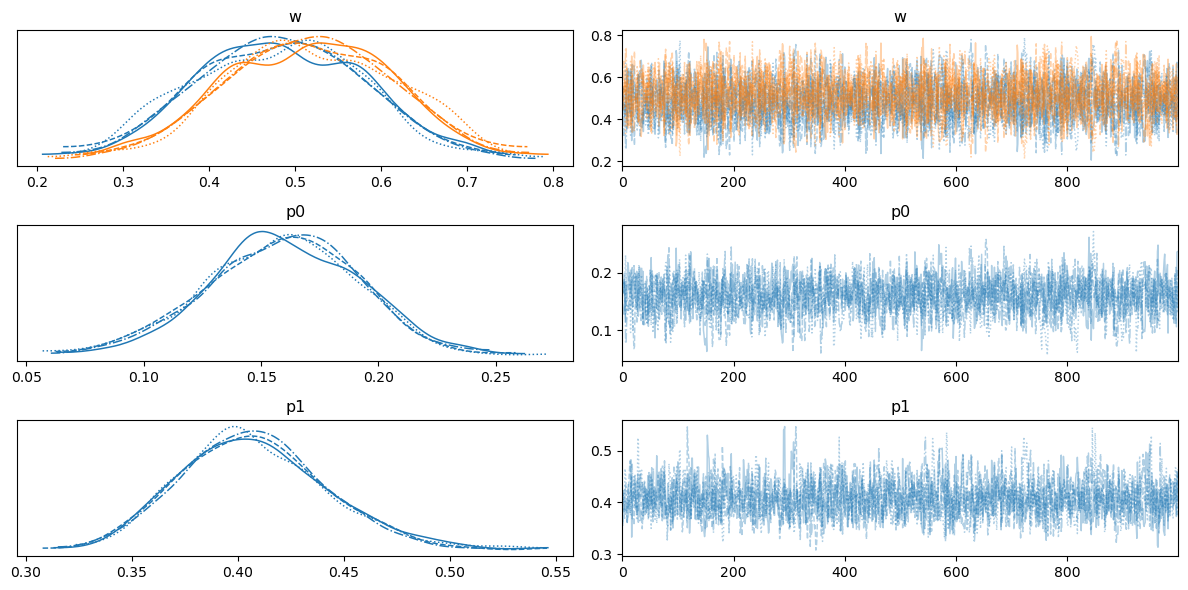

In [77]:
az.plot_trace(trace_6)
plt.tight_layout();

## Does it bias my results?

In [84]:
seed = np.random.seed(13579)
sim_data = simulate_experiment(rate=0.65,independents_p=0.1,conformist_p=0.45,n=7,precision=200)

In [85]:
# pymc model

with pm.Model() as model_7:

    # mixture weights

    w = pm.Dirichlet('w',[10,10])

    # mixture components

    p0 = pm.Beta('p0',1,2) # independent component
    p1 = pm.Beta('p1',2,1) # conformist component
    components = [pm.Binomial.dist(n=7,p=p0),pm.Binomial.dist(n=7,p=p1)]

    # order constraint
    # potentials have a complicated syntax.
    # the steps are, from innermost function to outermost function,
    # - lt = less then
    # - switch = if p0 < p1, return 1 (good). if not, return 0.05 (bad)
    # - log to convert into a scale pymc understands

    pm.Potential('order',pm.math.log(pm.math.switch(pm.math.lt(p0,p1), 1, 0.05)))

    # likelihood

    y = pm.Mixture('error',w=w,comp_dists=components,observed=sim_data)

In [86]:
with model_7:
    trace_7 = pm.sample(chains=4,random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


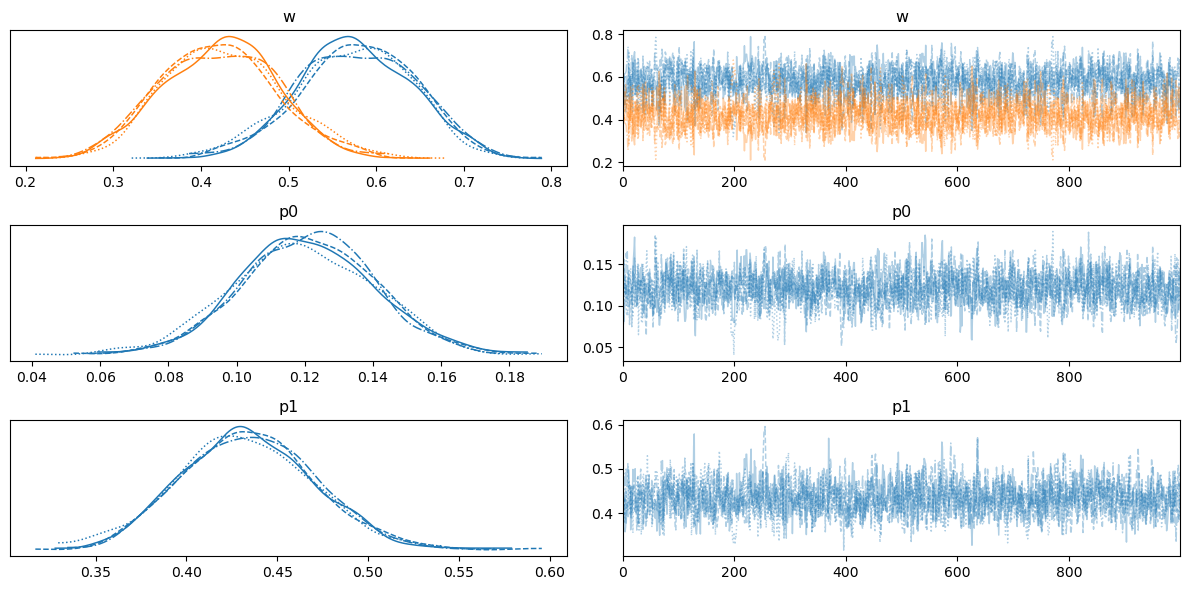

In [87]:
az.plot_trace(trace_7)
plt.tight_layout();